In [1]:
# --- Standard libraries
import pickle as pkl
import numpy as np
import heapq as hq
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# --- PyTorch
import torch
from torch_geometric.data import Batch
# --- RDKit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 300,300
# --- Bokeh
from bokeh.io import output_notebook, show, export_svg
from bokeh.models import Label
from bokeh.layouts import row
output_notebook()
# --- Science python
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance, spearmanr
# --- Modules from local files
from GNN import GNN
from utils.model import get_spec_prediction
from utils.utils import bokeh_spectra, calculate_rse, bokeh_hist

/home/samjhall/anaconda3/envs/pyg/lib/python3.10/site-packages/torch_geometric/typing.py:54: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.29' not found (required by /home/samjhall/anaconda3/envs/pyg/lib/python3.10/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/samjhall/anaconda3/envs/pyg/lib/python3.10/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.29' not found (required by /home/samjhall/anaconda3/envs/pyg/lib/python3.10/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


Loading BokehJS ...

### Coronene

#### Set model value

In [22]:
num_tasks = 200
num_layers = 3
emb_dim = 15
in_channels = [int(emb_dim), 64, 128]
out_channels = [64, 128, 256]
gnn_type = "gcn"
heads = 1
drop_ratio = 0.5
graph_pooling = "mean"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = 'model_gcn_mol_1.pt'

#### Load the saved model

In [23]:
num_tasks = 200

model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
model = model.to(device)
model.load_state_dict(torch.load("ML_models/" + model_name, map_location=device))

<All keys matched successfully>

#### Load the test data

In [13]:
test_dataset = torch.load("./processed/test_mol.pt")
test_dataset

XASDataset_mol(48)

#### Use model to predict from test data

In [14]:
# --- Create empty dictionary to contain spectra
predict = {}
true = {}

# --- Loop over all molecules in test dateset and assign to dictionary index
for index in range(len(test_dataset)):
    predict[index], true[index] = get_spec_prediction(model, index, test_dataset, device)

# --- Parse spectra into dictionary
model_dict = [predict, true]

# --- Save prediction results to file
with open("ML_models/results/" + model_name, "wb") as file:
    pkl.dump(model_dict, file)

#### View predictions

In [15]:
file = open('ML_models/results/' + model_name, 'rb')
data = pkl.load(file)

predict = data[0]
true = data[1]

#### Perform analysis of predictions

In [16]:
wasser = []
mse = []
rse = []
spear = []

for x in range(len(predict)):
    # Wasserstein metric
    wass_temp = wasserstein_distance(true[x], predict[x])
    wasser.append(wass_temp)
    # Mean squared error
    mse_temp = mean_squared_error(true[x], predict[x])
    mse.append(mse_temp)
    # RSE
    rse_temp = calculate_rse(true[x], predict[x])
    rse.append(rse_temp)
    # Spearman coefficient
    spear_temp = spearmanr(true[x], predict[x])
    spear.append(spear_temp[0])

ave_wasser = sum(wasser) / len(wasser)
ave_spear = sum(spear) / len(spear)
ave_mse = sum(mse) / len(mse)
ave_rse = sum(rse) / len(rse)

print(f"Average Wasserstein distance = {ave_wasser}")
print(f'Average spearman correlation coefficient = {ave_spear}')
print(f"Average MSE = {ave_mse}")
print(f'Average RSE = {ave_rse}')

Average Wasserstein distance = 0.0463393261410218
Average spearman correlation coefficient = 0.9567424498112455
Average MSE = 0.007797347220427279
Average RSE = 0.03975313203409314


In [17]:
rank_rse = hq.nsmallest(48, rse)

rank_graph = []

for x in range(48):
    rank_idx = rse.index(rank_rse[x])
    rank_graph.append(rank_idx)

print('The 5 best RSE values are:')
for x in range(5):
    print(f'RSE = {rank_rse[x]:.3f}, graph number = {rank_graph[x]}')

print('')
print('The 5 worst RSE values are:')
for x in range(-1, -6, -1):
    print(f'RSE = {rank_rse[x]:.3f}, graph number = {rank_graph[x]}')

The 5 best RSE values are:
RSE = 0.014, graph number = 21
RSE = 0.017, graph number = 42
RSE = 0.022, graph number = 22
RSE = 0.022, graph number = 31
RSE = 0.022, graph number = 7

The 5 worst RSE values are:
RSE = 0.100, graph number = 17
RSE = 0.078, graph number = 4
RSE = 0.072, graph number = 11
RSE = 0.064, graph number = 41
RSE = 0.059, graph number = 8


In [18]:
df = pd.read_pickle('./coronene_rse_values.pkl')

df['gine'] = rank_rse

In [19]:
df.to_pickle('coronene_rse_values.pkl')

#### View and compare predictions

In [10]:
# --- Plot best spectra prediction
p1 = bokeh_spectra(predict[rank_graph[0]], true[rank_graph[0]])
p2 = bokeh_spectra(predict[rank_graph[1]], true[rank_graph[1]])
p3 = bokeh_spectra(predict[rank_graph[2]], true[rank_graph[2]])
p = row(p1, p2, p3)
show(p)
#export_png(p, filename='GO_mol_best_RSE.png')
#export_svg(p, filename='test.svg')

In [11]:
# --- Plot worst spectra prediction
p1 = bokeh_spectra(predict[rank_graph[-1]], true[rank_graph[-1]])
p2 = bokeh_spectra(predict[rank_graph[-2]], true[rank_graph[-2]])
p3 = bokeh_spectra(predict[rank_graph[-3]], true[rank_graph[-3]])
p = row(p1, p2, p3)
show(p)
#export_png(p, filename='GO_mol_worst_RSE.png')

In [12]:
# --- Plot overview spectra prediction
p1 = bokeh_spectra(predict[rank_graph[0]], true[rank_graph[0]])
p1.title.text = 'Best RSE = ' + str('{:.3f}'.format(rank_rse[0]))
p1.title.align = 'center'
p1.title.text_font_size = '24px'
p2 = bokeh_spectra(predict[rank_graph[24]], true[rank_graph[24]])
p2.title.text = 'RSE = ' + str('{:.3f}'.format(rank_rse[24]))
p2.title.align = 'center'
p2.title.text_font_size = '24px'
p3 = bokeh_spectra(predict[rank_graph[-1]], true[rank_graph[-1]])
p3.title.text = 'Worst RSE = ' + str('{:.3f}'.format(rank_rse[-1]))
p3.title.align = 'center'
p3.title.text_font_size = '24px'
p3.legend.visible = False
p = row(p1, p2, p3)
show(p)
#export_png(p, filename='GO_mol_RSE.png')
#export_svg(p, filename='GO_mol_RSE.svg')


In [13]:
arr_hist, edges = np.histogram(rank_rse, bins=15, range=[0.015, 0.08])
values = pd.DataFrame({'rse_value': arr_hist,
                      'left': edges[:-1],
                      'right': edges[1:]})

p_hist = bokeh_hist(values, ave_rse)
label = Label(x=0.02, y=12, x_units='data', y_units='data', text='Average RSE = ' + str('{:.3f}'.format(ave_rse)), text_font_size='24px')
show(p_hist)

### Circumcoronene

#### Load the circumcoronene dataset

In [2]:
circum_dataset = torch.load('./processed/data_circ.pt')

In [3]:
# --- Show details of the dataset
print(circum_dataset)
print('-------------')
print(f'Number of graphs: {len(circum_dataset)}')
print(f'Number of features: {circum_dataset.num_features}')
print(f'Number of classes: {circum_dataset.num_classes}')
print('')

# --- Show details of the first molecule/graph in the dataset
circum_data = circum_dataset[1]

print(circum_data)
print('---------------')
print(f'Number of nodes: {circum_data.num_nodes}')
print(f'Number of edges: {circum_data.num_edges}')
print(f'Average node degree: {circum_data.num_edges / circum_data.num_nodes:.2f} ')
print(f'Has isolated nodes: {circum_data.has_isolated_nodes()}')
print(f'Has self loops: {circum_data.has_self_loops()}')
print(f'Is undirected: {circum_data.is_undirected()}')

XASDataset_mol(91)
-------------
Number of graphs: 91
Number of features: 15
Number of classes: 0

Data(x=[60, 15], edge_index=[2, 160], edge_attr=[160, 5], spectrum=[200], idx=[1], smiles='c12[c:1]3[c:2]4[c:3]([c:4]([H:75])[c:5]1[H:74])[c:38]([H:76])[c:39]1[c:40]5[c:9]4[c:8]4[c:7]6[c:6]3[c:24]3[c:23]([c:22]2[H:73])[c:31]([H:61])[c:32]([H:62])[c:33]2[c:25]3[c:26]3[c:10]6[c:11]6[c:12]7[c:13]4[c:42]4[c:41]5[c:49]([c:48]([H:78])[c:47]1[H:77])=[C:50]([H:79])[C:51]15[c:43]4[c:44]4[c:17]7[c:16]7[c:15]8[c:14]6[c:28]6[c:27]3[C:35]([O:58][H:67])([C:34]=2[H:72])[C:36]2([H:63])[C:37]([H:64])([c:29]6[c:30]([H:60])[c:18]8[c:19]([H:68])[c:20]([H:69])[c:21]7[c:46]([C:54](=[O:56])[O:57][H:66])[c:45]4[C:53]([H:70])([H:71])[C:52]1([H:65])[O:59]5)[O:55]2')
---------------
Number of nodes: 60
Number of edges: 160
Average node degree: 2.67 
Has isolated nodes: False
Has self loops: False
Is undirected: True


#### Load the model

In [12]:
num_tasks = 200
num_layers = 3
emb_dim = 15
in_channels = [int(emb_dim), 64, 128]
out_channels = [64, 128, 256]
gnn_type = "gine"
heads = 1
drop_ratio = 0.5
graph_pooling = "mean"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = 'model_gine_mol_1.pt'

In [13]:
num_tasks = 200

model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
model = model.to(device)
model.load_state_dict(torch.load("ML_models/" + model_name, map_location=device))

<All keys matched successfully>

In [14]:
cir_predict = {}
cir_true = {}

for index in range(len(circum_dataset)):
    cir_predict[index], cir_true[index] = get_spec_prediction(model, index, circum_dataset, device)

# --- Parse spectra into dictionary
cir_model_dict = [cir_predict, cir_true]

with open('ML_models/results/circum_' + model_name, 'wb') as file:
    pkl.dump(cir_model_dict, file)

In [15]:
file = open('ML_models/results/circum_' + model_name, 'rb')
cir_data = pkl.load(file)

cir_predict = cir_data[0]
cir_true = cir_data[1]

In [16]:
wasser = []
mse = []
rse = []
spear = []

for x in range(len(cir_predict)):
    # Wasserstein metric
    wass_temp = wasserstein_distance(cir_true[x], cir_predict[x])
    wasser.append(wass_temp)
    # Mean squared error
    mse_temp = mean_squared_error(cir_true[x], cir_predict[x])
    mse.append(mse_temp)
    # RSE
    rse_temp = calculate_rse(cir_true[x], cir_predict[x])
    rse.append(rse_temp)
    # Spearman
    spear_temp = spearmanr(cir_true[x], cir_predict[x])
    spear.append(spear_temp[0])

cir_ave_wasser = sum(wasser) / len(wasser)
cir_ave_spear = sum(spear) / len(spear)
cir_ave_mse = sum(mse) / len(mse)
cir_ave_rse = sum(rse) / len(rse)

print(f"Average Wasserstein distance = {cir_ave_wasser}")
print(f'Average Spearman correlation coefficiant = {cir_ave_spear}')
print(f"Average MSE = {cir_ave_mse}")
print(f'Average RSE = {cir_ave_rse}')

Average Wasserstein distance = 0.03181520736184589
Average Spearman correlation coefficiant = 0.9750382880451135
Average MSE = 0.004250437150463708
Average RSE = 0.039271267130970955


In [17]:
rank_rse = hq.nsmallest(91, rse)

rank_graph = []

for x in range(91):
    rank_idx = rse.index(rank_rse[x])
    rank_graph.append(rank_idx)

print('The 5 best RSE values are:')
for x in range(5):
    print(f'RSE = {rank_rse[x]:.3f}, graph number = {rank_graph[x]}')

print('')
print('The 5 worst RSE values are:')
for x in range(-1, -6, -1):
    print(f'RSE = {rank_rse[x]:.3f}, graph number = {rank_graph[x]}')

The 5 best RSE values are:
RSE = 0.023, graph number = 79
RSE = 0.026, graph number = 31
RSE = 0.026, graph number = 19
RSE = 0.026, graph number = 18
RSE = 0.027, graph number = 38

The 5 worst RSE values are:
RSE = 0.073, graph number = 34
RSE = 0.063, graph number = 15
RSE = 0.061, graph number = 64
RSE = 0.059, graph number = 28
RSE = 0.059, graph number = 77


In [18]:
df = pd.read_pickle('./circum_rse_values.pkl')

df['gine'] = rank_rse

In [19]:
df.to_pickle('./circum_rse_values.pkl')

In [28]:
# --- Plot best spectra prediction
p1 = bokeh_spectra(cir_predict[rank_graph[0]], cir_true[rank_graph[0]])
p2 = bokeh_spectra(cir_predict[rank_graph[1]], cir_true[rank_graph[1]])
p3 = bokeh_spectra(cir_predict[rank_graph[2]], cir_true[rank_graph[2]])
p = row(p1, p2, p3)
show(p)
#export_png(p, filename='GO_mol_cir_best_RSE.png')

In [29]:
# --- Plot best spectra prediction
p1 = bokeh_spectra(cir_predict[rank_graph[-1]], cir_true[rank_graph[-1]])
p2 = bokeh_spectra(cir_predict[rank_graph[-2]], cir_true[rank_graph[-2]])
p3 = bokeh_spectra(cir_predict[rank_graph[-3]], cir_true[rank_graph[-3]])
p = row(p1, p2, p3)
show(p)
#export_png(p, filename='GO_mol_cir_worst_RSE.png')

In [30]:
# --- Plot best spectra prediction
p1 = bokeh_spectra(cir_predict[rank_graph[0]], cir_true[rank_graph[0]])
p1.title.text = 'Best RSE = ' + str('{:.3f}'.format(rank_rse[0]))
p1.title.align = 'center'
p1.title.text_font_size = '24px'
p2 = bokeh_spectra(cir_predict[rank_graph[44]], cir_true[rank_graph[44]])
p3 = bokeh_spectra(cir_predict[rank_graph[-1]], cir_true[rank_graph[-1]])
p3.title.text = 'Worst RSE = ' + str('{:.3f}'.format(rank_rse[-1]))
p3.title.align = 'center'
p3.title.text_font_size = '24px'
p3.legend.visible = False
p = row(p1, p3)
show(p)
#export_png(p, filename='GO_cir_RSE.png')

In [37]:
arr_hist, edges = np.histogram(rank_rse, bins=20, range=[0.02, 0.08])
values = pd.DataFrame({'rse_value': arr_hist,
                      'left': edges[:-1],
                      'right': edges[1:]})

p_hist = bokeh_hist(values, cir_ave_rse)
label = Label(x=100, y=100, x_units='screen', y_units='screen', text='Average RSE = ' + str('{:.3f}'.format(ave_rse)), text_font_size='24px')
show(p_hist)

In [37]:
from bokeh.plotting import figure
from bokeh.models import SingleIntervalTicker, LinearAxis, Span

p = figure(
        x_axis_label = 'RSE value', y_axis_label = 'Frequency',
        x_range = (cir_edges[0], cir_edges[-1]), y_range = (0, max(hist)+10),
        width = 500, height = 450,
        outline_line_color = 'black', outline_line_width = 2
    )

p.toolbar.logo = None
p.toolbar_location = None
p.min_border = 25

# --- x-axis settings
p.xaxis.ticker.desired_num_ticks = 3
p.xaxis.axis_label_text_font_size = '24px'
p.xaxis.major_label_text_font_size = '24px'
p.xaxis.major_tick_in = 0
p.xaxis.major_tick_out = 10
p.xaxis.minor_tick_out = 6
p.xaxis.major_tick_line_width = 2
p.xaxis.minor_tick_line_width = 2
p.xaxis.major_tick_line_color = 'black'
p.xaxis.minor_tick_line_color = 'black'
p.xaxis[0].ticker.desired_num_ticks = 3
# --- y-axis settings
p.yaxis.axis_label_text_font_size = '24px'
p.yaxis.major_label_text_font_size = '24px'
p.yaxis.major_tick_in = 0
p.yaxis.major_tick_out = 10
p.yaxis.major_tick_line_width = 2
p.yaxis.major_tick_line_color = 'black'
p.yaxis.minor_tick_line_color = None
p.yaxis.major_label_text_color = 'black'
# --- grid settings
p.grid.grid_line_color = 'grey'
p.grid.grid_line_alpha = 0.3
p.grid.grid_line_width = 1.5
p.grid.grid_line_dash = "dashed"

# --- Format x-axis
ticker = SingleIntervalTicker(interval=20)
xaxis = LinearAxis(ticker=ticker)
p.add_layout(xaxis, 'below')

# --- Plot data
# --- Add histogram
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color='skyblue', line_color='black', fill_alpha=1.0)
p.quad(top=cir_hist, bottom=0, left=cir_edges[:-1], right=cir_edges[1:], fill_color='tomato', line_color='black', fill_alpha=0.4)
# --- Add average line
vline = Span(location=ave_rse, dimension='height', line_color='dodgerblue', line_width=3, line_dash='dashed')
vline1 = Span(location=cir_ave_rse, dimension='height', line_color='firebrick', line_width=3, line_dash='dashed')
p.renderers.extend([vline, vline1])
# --- Add labels
l1 = Label(x=0.016, y=102, x_units='data', y_units='data', text='RSE = 0.038', text_font_size='24px')
l2 = Label(x=0.044, y=102, x_units='data', y_units='data', text='RSE = 0.043', text_font_size='24px')

p.add_layout(l1)
p.add_layout(l2)

show(p)
#export_png(p, filename='hist_comp.png')

### Boxplot

In [20]:
cor_df = pd.read_pickle('./circum_rse_values.pkl')

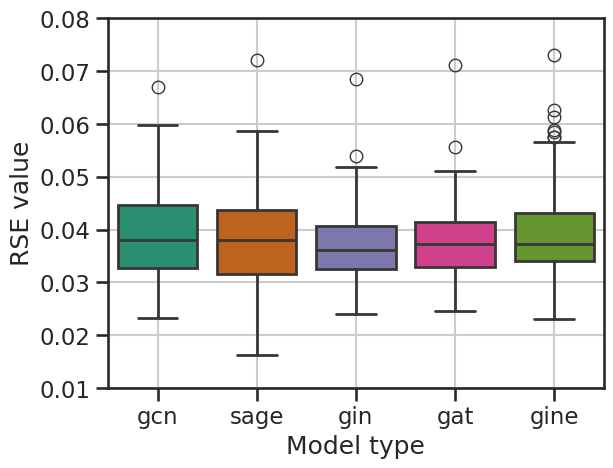

In [21]:
sns.set_style('white')
sns.set_context('talk')
sns.set_style('ticks')
sns.boxplot(data=cor_df, palette='Dark2', linewidth=2)
plt.grid()
plt.ylim(0.01, 0.08)
plt.ylabel('RSE value')
plt.xlabel('Model type')
#plt.savefig('coronene_box.svg', bbox_inches='tight')
plt.show()